In [8]:
# 配置matplotlib中文显示
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 验证配置
print("✅ matplotlib中文字体配置完成")
print(f"当前字体: {plt.rcParams['font.sans-serif']}")


✅ matplotlib中文字体配置完成
当前字体: ['Arial Unicode MS', 'SimHei', 'STHeiti', 'DejaVu Sans']


# EMG 离散手势识别训练教程

本notebook将带你从零开始理解EMG手势识别模型的训练过程。

## 目标
- 理解EMG数据结构（16通道肌电信号）
- 学习滑动窗口数据处理
- 掌握时序模型训练流程
- 可视化训练过程和预测结果

## 1. 环境准备和参数配置

In [1]:
import os
import logging
from pathlib import Path
from enum import Enum
from typing import List, Optional, Dict, Tuple
from dataclasses import dataclass

import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 设置随机种子保证可复现
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print(f"✅ PyTorch版本: {torch.__version__}")
print(f"✅ 设备: {'GPU' if torch.cuda.is_available() else 'CPU'}")

/Users/chenee/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ PyTorch版本: 2.2.2
✅ 设备: CPU


In [ ]:
# 训练参数
BATCH_SIZE = 64
MAX_EPOCHS = 1  # 快速演示用，完整训练改为250
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0
GRAD_CLIP = 10.0

# 数据参数
DATA_DIR = Path.home() / 'emg_data'  # 小样本数据在根目录
SPLIT_CSV = Path.home() / 'emg_data' / 'discrete_gestures_corpus.csv'
CHECKPOINT_DIR = Path('logs')
CHECKPOINT_DIR.mkdir(exist_ok=True)

# 窗口参数
SAMPLE_RATE = 2000  # Hz
WINDOW_DURATION = 0.256  # 秒
WINDOW_SIZE = int(SAMPLE_RATE * WINDOW_DURATION)  # 512样本点
WINDOW_STRIDE = int(SAMPLE_RATE * 0.032)  # 64样本点，88%重叠

print(f"📊 批量大小: {BATCH_SIZE}")
print(f"⏱️  窗口大小: {WINDOW_SIZE} 样本点 ({WINDOW_DURATION*1000:.0f}ms)")
print(f"📏 步长: {WINDOW_STRIDE} 样本点 ({WINDOW_STRIDE/SAMPLE_RATE*1000:.0f}ms)")
print(f"💾 数据目录: {DATA_DIR}")

📊 批量大小: 64
⏱️  窗口大小: 512 样本点 (256ms)
📏 步长: 64 样本点 (32ms)
💾 数据目录: /Users/chenee/emg_data


## 2. 手势类型定义

我们识别9种离散手势：
- 食指按下/释放 (index_press/release)
- 中指按下/释放 (middle_press/release) 
- 拇指按下/释放/外展 (thumb_press/release/adduction)

In [3]:
class GestureType(Enum):
    """9种手势类型（根据实际数据中的标签）"""
    index_press = 'index_press'
    index_release = 'index_release'
    middle_press = 'middle_press'
    middle_release = 'middle_release'
    thumb_up = 'thumb_up'
    thumb_down = 'thumb_down'
    thumb_in = 'thumb_in'
    thumb_out = 'thumb_out'
    thumb_click = 'thumb_click'

# 创建手势名称到索引的映射
gesture_to_idx = {g.value: i for i, g in enumerate(GestureType)}
idx_to_gesture = {i: g.value for i, g in enumerate(GestureType)}

print(f"📝 总共 {len(GestureType)} 种手势类型：")
for idx, name in idx_to_gesture.items():
    print(f"  [{idx}] {name}")

📝 总共 9 种手势类型：
  [0] index_press
  [1] index_release
  [2] middle_press
  [3] middle_release
  [4] thumb_up
  [5] thumb_down
  [6] thumb_in
  [7] thumb_out
  [8] thumb_click


## 3. 数据分割加载

从CSV文件读取训练/验证/测试集的划分

In [4]:
@dataclass
class DataSplit:
    """数据集分割信息"""
    train_datasets: List[str]
    val_datasets: List[str]
    test_datasets: List[str]
    
    @staticmethod
    def from_csv(csv_path: Path) -> 'DataSplit':
        """从CSV读取数据分割"""
        df = pd.read_csv(csv_path)
        train = df[df['split'] == 'train']['dataset'].tolist()
        val = df[df['split'] == 'val']['dataset'].tolist()
        test = df[df['split'] == 'test']['dataset'].tolist()
        return DataSplit(train, val, test)

# 加载数据分割
if SPLIT_CSV.exists():
    data_split = DataSplit.from_csv(SPLIT_CSV)
    print(f"📂 训练集: {len(data_split.train_datasets)} 个文件")
    print(f"📂 验证集: {len(data_split.val_datasets)} 个文件")
    print(f"📂 测试集: {len(data_split.test_datasets)} 个文件")
    print(f"\n示例文件名: {data_split.train_datasets[0] if data_split.train_datasets else data_split.test_datasets[0]}")
else:
    print(f"⚠️  未找到 {SPLIT_CSV}")

📂 训练集: 956 个文件
📂 验证集: 118 个文件
📂 测试集: 118 个文件

示例文件名: discrete_gestures_user_017_dataset_000.hdf5


## 4. EMG数据探索

让我们打开一个HDF5文件，查看EMG数据的结构

In [5]:
# 找一个存在的HDF5文件
sample_files = list(DATA_DIR.glob('discrete_gestures_*.hdf5'))[:3]
print(f"🔍 找到 {len(sample_files)} 个HDF5文件\n")

# 初始化变量
emg_data = None
event_times = None
event_labels = None

if sample_files:
    sample_file = sample_files[0]
    print(f"📁 查看文件: {sample_file.name}")
    print(f"   大小: {sample_file.stat().st_size / 1024 / 1024:.1f} MB\n")
    
    # 这是一个pandas HDFStore格式的文件
    with h5py.File(sample_file, 'r') as f:
        print("📦 HDF5文件结构:")
        print(f"  ├─ data: structured array")
        
        # 读取EMG数据
        data = f['data']
        emg_data = data['emg'][:]  # shape: (N, 16)
        time_stamps = data['time'][:]  # shape: (N,)
        
        print(f"  │  ├─ emg: {emg_data.shape}")
        print(f"  │  └─ time: {time_stamps.shape}")
    
    # 读取事件信息（prompts）
    with pd.HDFStore(sample_file, 'r') as store:
        prompts_df = store['prompts']
        print(f"  ├─ prompts: DataFrame {prompts_df.shape}")
        print(f"  │  └─ columns: {list(prompts_df.columns)}")
        
        # 提取事件时间和标签
        event_labels = prompts_df['name'].tolist()
        # 将绝对时间戳转换为相对时间（秒）
        start_time = time_stamps[0]
        event_times = (prompts_df['time'].values - start_time)
        
        print(f"\n📊 数据统计:")
        print(f"  EMG形状: {emg_data.shape}")
        print(f"  EMG范围: [{emg_data.min():.2f}, {emg_data.max():.2f}]")
        print(f"  时长: {(time_stamps[-1] - time_stamps[0]):.2f} 秒")
        print(f"  采样率: ~{len(emg_data) / (time_stamps[-1] - time_stamps[0]):.0f} Hz")
        print(f"  事件数量: {len(event_times)} 个")
        print(f"  事件类型: {set(event_labels)}")
        print(f"\n✅ 成功加载数据，可以继续运行后续cell")
else:
    print("❌ 未找到数据文件")

🔍 找到 3 个HDF5文件

📁 查看文件: discrete_gestures_user_002_dataset_000.hdf5
   大小: 383.0 MB

📦 HDF5文件结构:
  ├─ data: structured array
  │  ├─ emg: (5548256, 16)
  │  └─ time: (5548256,)
  ├─ prompts: DataFrame (1900, 2)
  │  └─ columns: ['name', 'time']

📊 数据统计:
  EMG形状: (5548256, 16)
  EMG范围: [-1779.19, 1651.98]
  时长: 2774.08 秒
  采样率: ~2000 Hz
  事件数量: 1900 个
  事件类型: {'index_press', 'thumb_in', 'thumb_out', 'thumb_down', 'thumb_click', 'middle_release', 'middle_press', 'thumb_up', 'index_release'}

✅ 成功加载数据，可以继续运行后续cell


### 可视化EMG信号和事件标注

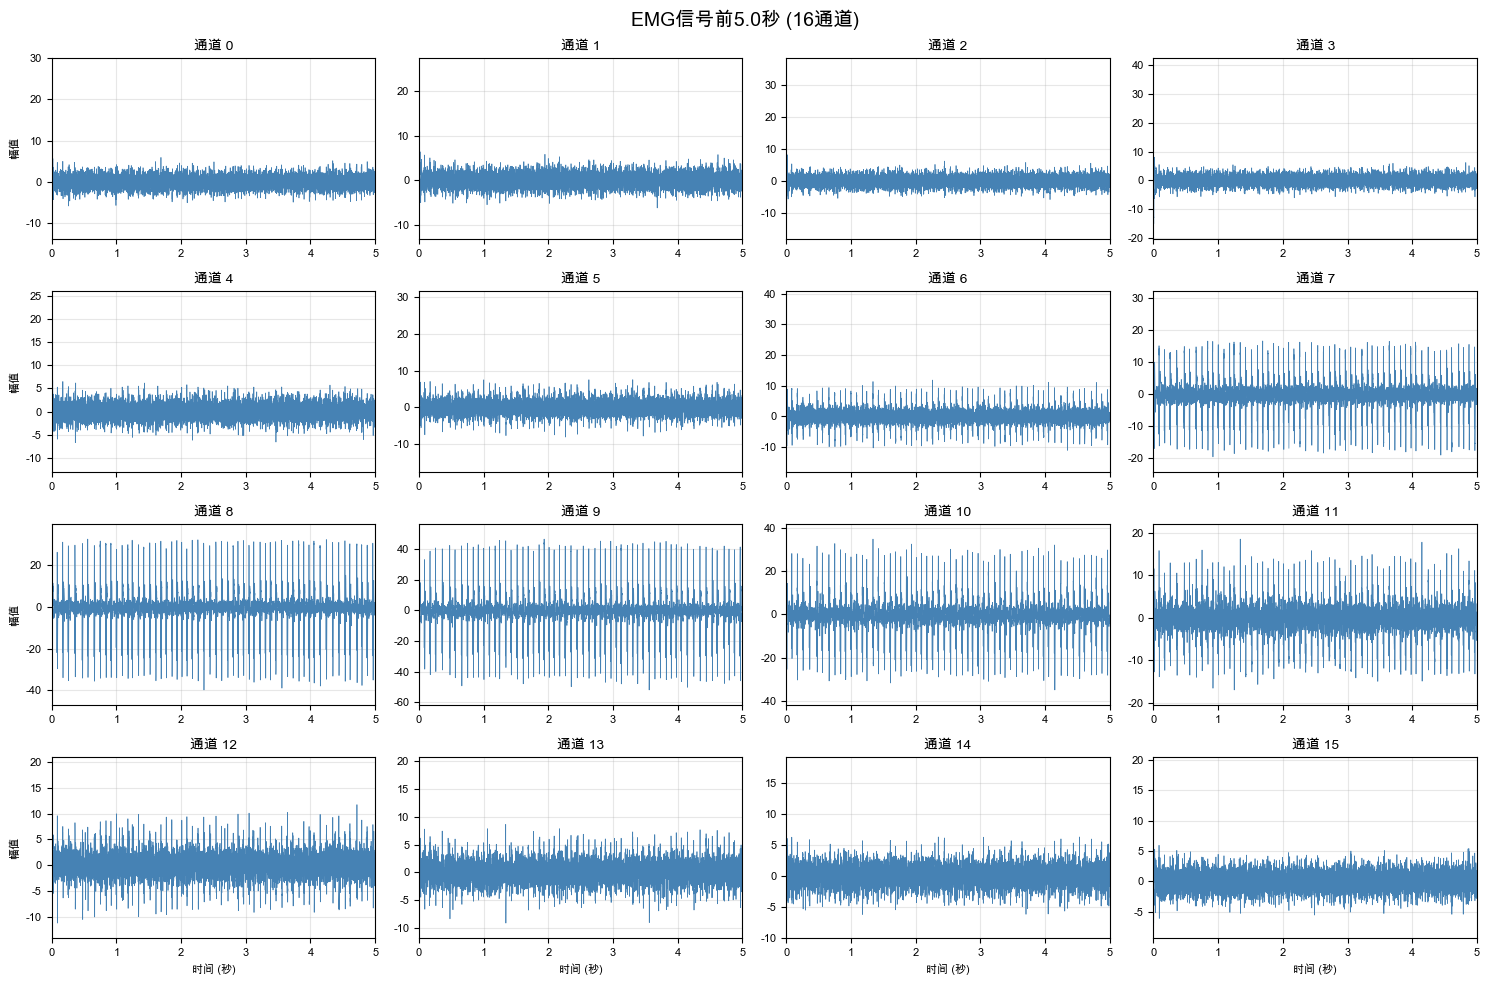

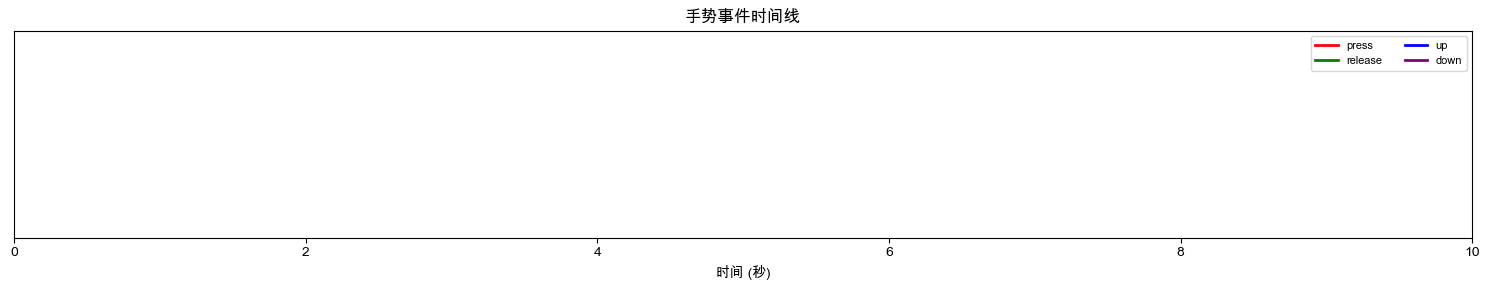


📈 前10秒内有 0 个手势事件


In [9]:
if sample_files and emg_data is not None:
    # 可视化前5秒的EMG信号
    duration = 5.0  # 秒
    n_samples = int(duration * SAMPLE_RATE)
    n_samples = min(n_samples, len(emg_data))  # 防止越界
    time_axis = np.arange(n_samples) / SAMPLE_RATE
    
    fig, axes = plt.subplots(4, 4, figsize=(15, 10))
    fig.suptitle(f'EMG信号前{duration}秒 (16通道)', fontsize=14, fontweight='bold')
    
    for ch in range(16):
        ax = axes[ch // 4, ch % 4]
        ax.plot(time_axis, emg_data[:n_samples, ch], linewidth=0.5, color='steelblue')
        ax.set_title(f'通道 {ch}', fontsize=10)
        ax.set_xlim(0, duration)
        # 自适应y轴范围
        y_min, y_max = emg_data[:n_samples, ch].min(), emg_data[:n_samples, ch].max()
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        if ch >= 12:
            ax.set_xlabel('时间 (秒)', fontsize=8)
        if ch % 4 == 0:
            ax.set_ylabel('幅值', fontsize=8)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 显示事件时间线
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.set_title('手势事件时间线', fontweight='bold')
    
    # 只显示前10秒的事件
    mask = event_times < 10.0
    colors = {'press': 'red', 'release': 'green', 'up': 'blue', 
              'down': 'purple', 'in': 'orange', 'out': 'cyan', 'click': 'magenta'}
    
    for t, label in zip(event_times[mask], np.array(event_labels)[mask]):
        # 根据标签选择颜色
        color = 'gray'
        for key, c in colors.items():
            if key in label:
                color = c
                break
        ax.axvline(t, color=color, alpha=0.5, linewidth=2)
        # 简化标签显示
        short_label = label.replace('_press', '↓').replace('_release', '↑').replace('thumb_', 'T')
        ax.text(t, 0.5, short_label[:5], rotation=90, 
               fontsize=7, ha='right', va='center')
    
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1)
    ax.set_xlabel('时间 (秒)')
    ax.set_yticks([])
    ax.legend(handles=[plt.Line2D([0], [0], color=c, linewidth=2, label=k) 
                      for k, c in list(colors.items())[:4]], 
             loc='upper right', fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 前10秒内有 {mask.sum()} 个手势事件")
else:
    print("⚠️  请先运行上一个cell加载数据")

## 5. EMG录制数据类

封装HDF5文件读取和时间切片功能

In [13]:
class EmgRecording:
    """EMG录制数据的封装类"""
    
    def __init__(self, filepath: Path, sample_rate: int = 2000):
        self.filepath = filepath
        self.sample_rate = sample_rate
        
        # 读取structured array数据
        with h5py.File(filepath, 'r') as f:
            data = f['data']
            self.emg = data['emg'][:]  # (N, 16)
            time_stamps = data['time'][:]  # (N,) 绝对时间戳
        
        # 读取事件信息
        with pd.HDFStore(filepath, 'r') as store:
            prompts_df = store['prompts']
            self.event_labels = prompts_df['name'].tolist()
            # 转换为相对时间（秒）
            start_time = time_stamps[0]
            self.event_times = (prompts_df['time'].values - start_time)
        
        # 计算实际时长
        self.duration = time_stamps[-1] - time_stamps[0]
    
    def get_slice(self, start_time: float, end_time: float) -> np.ndarray:
        """获取时间片段的EMG数据"""
        start_idx = int(start_time * self.sample_rate)
        end_idx = int(end_time * self.sample_rate)
        start_idx = max(0, min(start_idx, len(self.emg)))
        end_idx = max(0, min(end_idx, len(self.emg)))
        return self.emg[start_idx:end_idx]
    
    def get_events_in_range(self, start_time: float, end_time: float):
        """获取时间范围内的事件"""
        mask = (self.event_times >= start_time) & (self.event_times < end_time)
        return self.event_times[mask], [self.event_labels[i] for i, m in enumerate(mask) if m]

# 测试
if sample_files:
    recording = EmgRecording(sample_files[0])
    print(f"✅ 加载录制文件: {sample_files[0].name}")
    print(f"   EMG形状: {recording.emg.shape}")
    print(f"   时长: {recording.duration:.2f} 秒")
    print(f"   事件数: {len(recording.event_times)}")
    
    # 测试切片
    slice_data = recording.get_slice(1.0, 2.0)
    print(f"\n   切片测试 [1.0s, 2.0s]: shape={slice_data.shape}")
    
    # 测试事件查询
    times, labels = recording.get_events_in_range(0, 10)
    print(f"   事件查询 [0s, 10s]: {len(times)} 个事件")
    if labels:
        print(f"   事件示例: {labels[:3]}")

✅ 加载录制文件: discrete_gestures_user_002_dataset_000.hdf5
   EMG形状: (5548256, 16)
   时长: 2774.08 秒
   事件数: 1900

   切片测试 [1.0s, 2.0s]: shape=(2000, 16)
   事件查询 [0s, 10s]: 0 个事件


## 6. 离散手势转换器

将事件时间转换为脉冲目标信号

In [14]:
class DiscreteGesturesTransform:
    """将事件时间转换为脉冲目标"""
    
    def __init__(self, sample_rate: int = 2000, pulse_width: float = 0.1):
        self.sample_rate = sample_rate
        self.pulse_width = pulse_width
        self.pulse_samples = int(pulse_width * sample_rate)
        self.num_gestures = len(GestureType)
    
    def __call__(self, emg: np.ndarray, event_times: np.ndarray, 
                 event_labels: List[str]) -> np.ndarray:
        """
        Args:
            emg: (T, 16) EMG数据
            event_times: (N,) 事件时间
            event_labels: (N,) 事件标签
        Returns:
            targets: (T, 9) 脉冲目标
        """
        T = len(emg)
        targets = np.zeros((T, self.num_gestures), dtype=np.float32)
        
        for event_time, label in zip(event_times, event_labels):
            if label not in gesture_to_idx:
                continue
            
            gesture_idx = gesture_to_idx[label]
            event_sample = int(event_time * self.sample_rate)
            
            # 在事件时刻周围设置脉冲
            start = max(0, event_sample - self.pulse_samples // 2)
            end = min(T, event_sample + self.pulse_samples // 2)
            targets[start:end, gesture_idx] = 1.0
        
        return targets

# 测试转换器
if sample_files:
    transform = DiscreteGesturesTransform()
    print(f"🔄 脉冲宽度: {transform.pulse_width}秒 ({transform.pulse_samples}个样本点)\n")
    
    # 获取前10秒数据
    test_emg = recording.get_slice(0, 10)
    test_times, test_labels = recording.get_events_in_range(0, 10)
    
    # 生成目标
    targets = transform(test_emg, test_times, test_labels)
    print(f"输入EMG: {test_emg.shape}")
    print(f"输出目标: {targets.shape}")
    print(f"事件数: {len(test_times)}")
    print(f"\n每个手势的激活样本数:")
    for i in range(9):
        count = (targets[:, i] > 0).sum()
        if count > 0:
            print(f"  {idx_to_gesture[i]}: {count} 个样本点")

🔄 脉冲宽度: 0.1秒 (200个样本点)

输入EMG: (20000, 16)
输出目标: (20000, 9)
事件数: 0

每个手势的激活样本数:


### 可视化目标脉冲

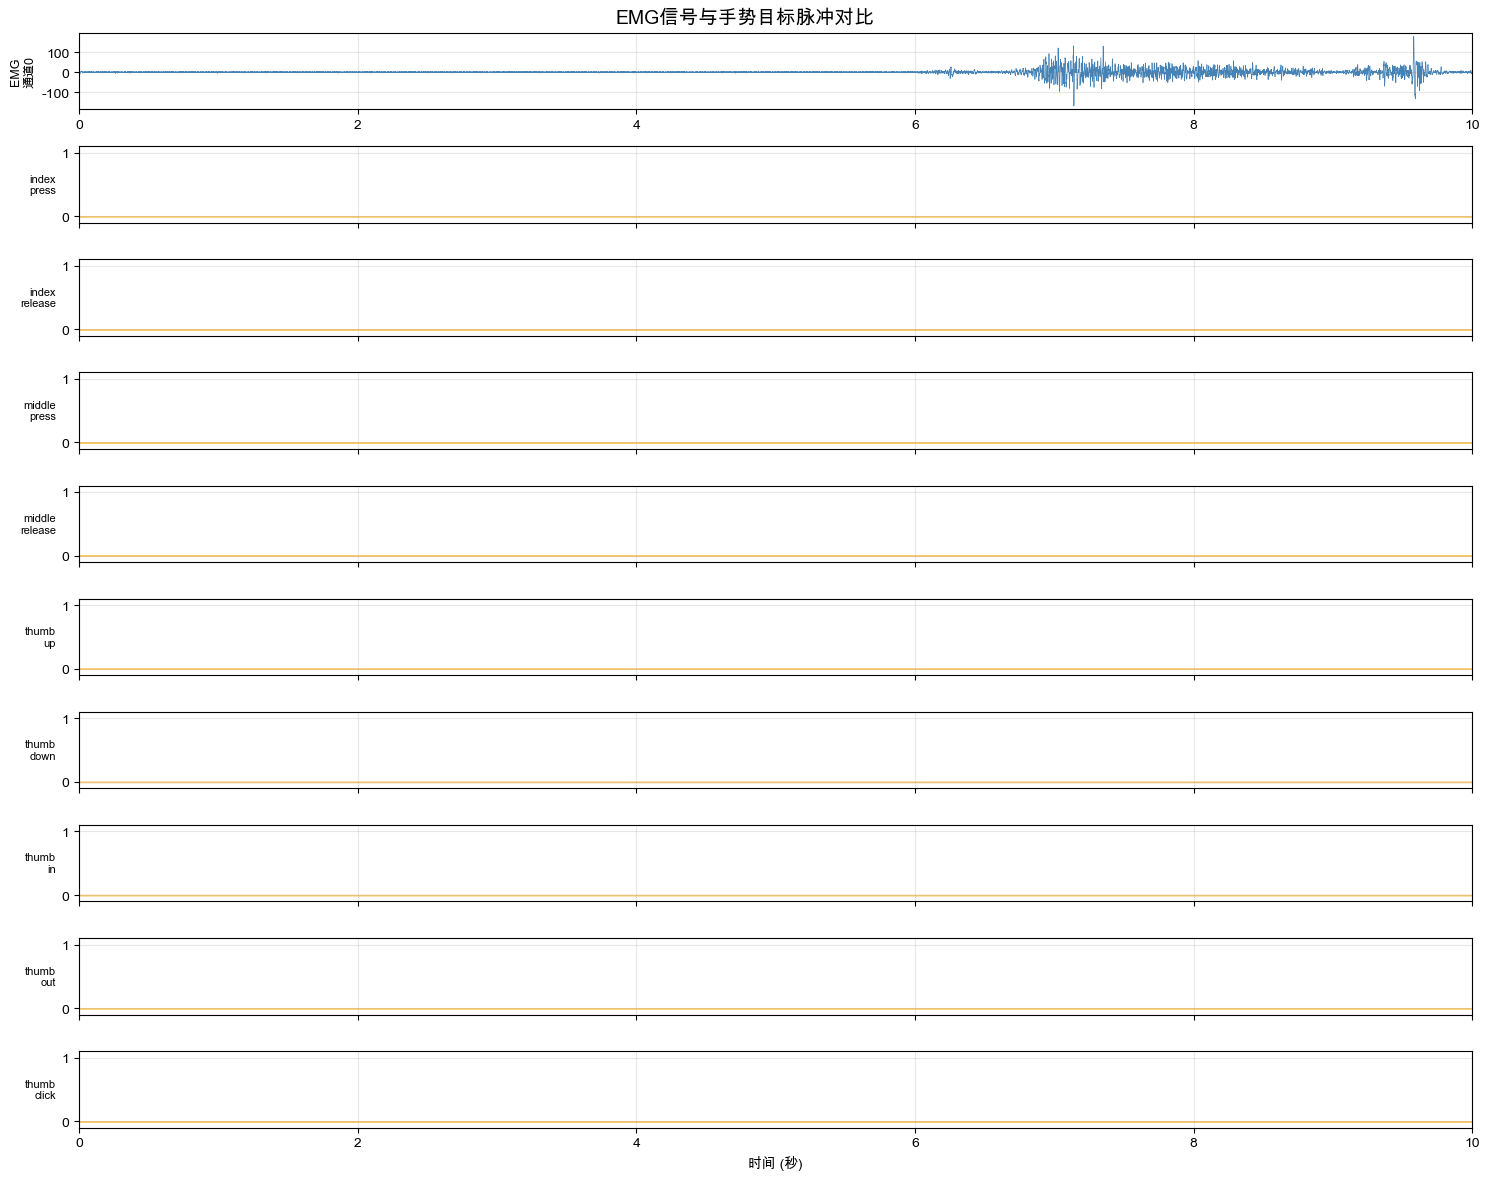

In [15]:
if sample_files:
    fig, axes = plt.subplots(10, 1, figsize=(15, 12))
    fig.suptitle('EMG信号与手势目标脉冲对比', fontweight='bold', fontsize=14)
    
    time_axis = np.arange(len(test_emg)) / SAMPLE_RATE
    
    # 显示一个EMG通道
    axes[0].plot(time_axis, test_emg[:, 0], linewidth=0.5, color='steelblue')
    axes[0].set_ylabel('EMG\n通道0', fontsize=9)
    axes[0].set_xlim(0, 10)
    axes[0].grid(alpha=0.3)
    
    # 显示9个手势目标
    for i in range(9):
        axes[i+1].fill_between(time_axis, 0, targets[:, i], 
                               color='orange', alpha=0.6)
        axes[i+1].set_ylabel(idx_to_gesture[i].replace('_', '\n'), 
                            fontsize=8, rotation=0, ha='right', va='center')
        axes[i+1].set_xlim(0, 10)
        axes[i+1].set_ylim(-0.1, 1.1)
        axes[i+1].grid(alpha=0.3)
        if i < 8:
            axes[i+1].set_xticklabels([])
    
    axes[-1].set_xlabel('时间 (秒)')
    plt.tight_layout()
    plt.show()

## 7. 滑动窗口数据集

使用滑动窗口将连续EMG信号切分成固定长度的片段

In [17]:
class WindowedEmgDataset(Dataset):
    """滑动窗口EMG数据集"""
    
    def __init__(self, recording: EmgRecording, window_size: int, 
                 window_stride: int, transform=None, jitter: float = 0.0):
        self.recording = recording
        self.window_size = window_size
        self.window_stride = window_stride
        self.transform = transform
        self.jitter = jitter
        
        # 计算窗口数量
        total_samples = len(recording.emg)
        self.num_windows = (total_samples - window_size) // window_stride + 1
    
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        # 计算窗口起始位置
        start_sample = idx * self.window_stride
        
        # 添加随机抖动（训练时数据增强）
        if self.jitter > 0:
            jitter_samples = int(np.random.uniform(-self.jitter, self.jitter) * self.window_stride)
            start_sample = max(0, min(start_sample + jitter_samples, 
                                     len(self.recording.emg) - self.window_size))
        
        end_sample = start_sample + self.window_size
        
        # 提取EMG窗口
        emg_window = self.recording.emg[start_sample:end_sample]
        
        # 计算对应的时间范围
        start_time = start_sample / self.recording.sample_rate
        end_time = end_sample / self.recording.sample_rate
        
        # 获取这个时间范围内的事件
        event_times, event_labels = self.recording.get_events_in_range(start_time, end_time)
        
        # 转换为相对时间（相对于窗口起始）
        event_times = event_times - start_time
        
        # 应用转换（生成目标）
        if self.transform:
            targets = self.transform(emg_window, event_times, event_labels)
        else:
            targets = np.zeros((self.window_size, len(GestureType)), dtype=np.float32)
        
        # 转为torch tensor
        emg_tensor = torch.from_numpy(emg_window).float()  # (T, 16)
        target_tensor = torch.from_numpy(targets).float()  # (T, 9)
        
        return emg_tensor, target_tensor

# 测试数据集
if sample_files:
    dataset = WindowedEmgDataset(
        recording=recording,
        window_size=WINDOW_SIZE,
        window_stride=WINDOW_STRIDE,
        transform=transform
    )
    
    print(f"📦 数据集大小: {len(dataset)} 个窗口")
    print(f"   总时长: {recording.duration:.1f}秒")
    print(f"   窗口时长: {WINDOW_SIZE/SAMPLE_RATE:.3f}秒")
    print(f"   窗口重叠: {(WINDOW_SIZE-WINDOW_STRIDE)/WINDOW_SIZE*100:.0f}%")
    
    # 获取一个样本
    emg, target = dataset[0]
    print(f"\n单个样本:")
    print(f"  EMG: {emg.shape} {emg.dtype}")
    print(f"  目标: {target.shape} {target.dtype}")
    print(f"  EMG范围: [{emg.min():.3f}, {emg.max():.3f}]")
    print(f"  目标激活: {(target.sum(dim=0) > 0).sum().item()} / 9 个手势")

📦 数据集大小: 86684 个窗口
   总时长: 2774.1秒
   窗口时长: 0.256秒
   窗口重叠: 88%

单个样本:
  EMG: torch.Size([512, 16]) torch.float32
  目标: torch.Size([512, 9]) torch.float32
  EMG范围: [-41.891, 38.561]
  目标激活: 0 / 9 个手势


### 可视化数据集样本

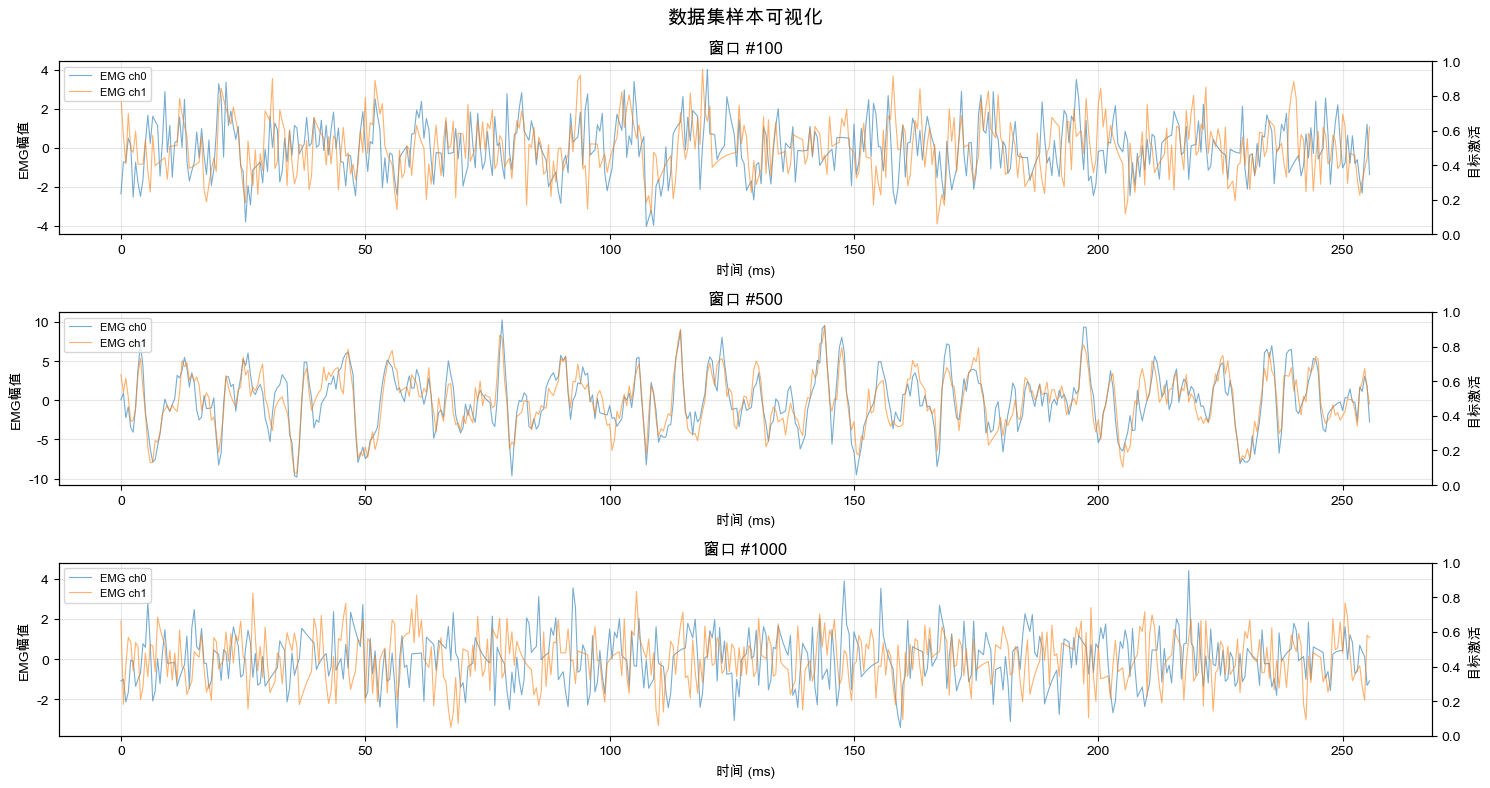

In [18]:
if sample_files:
    # 随机选择几个窗口可视化
    fig, axes = plt.subplots(3, 1, figsize=(15, 8))
    fig.suptitle('数据集样本可视化', fontweight='bold', fontsize=14)
    
    for plot_idx, window_idx in enumerate([100, 500, 1000]):
        if window_idx >= len(dataset):
            continue
        
        emg, target = dataset[window_idx]
        time_ms = np.arange(len(emg)) / SAMPLE_RATE * 1000
        
        ax = axes[plot_idx]
        
        # 绘制EMG（只显示2个通道）
        ax.plot(time_ms, emg[:, 0].numpy(), label='EMG ch0', alpha=0.6, linewidth=0.8)
        ax.plot(time_ms, emg[:, 1].numpy(), label='EMG ch1', alpha=0.6, linewidth=0.8)
        
        # 叠加目标（缩放到EMG范围）
        ax2 = ax.twinx()
        for i in range(9):
            if target[:, i].sum() > 0:
                ax2.fill_between(time_ms, 0, target[:, i].numpy(), 
                                alpha=0.3, label=idx_to_gesture[i])
        
        ax.set_xlabel('时间 (ms)')
        ax.set_ylabel('EMG幅值')
        ax2.set_ylabel('目标激活')
        ax.set_title(f'窗口 #{window_idx}')
        ax.legend(loc='upper left', fontsize=8)
        if target.sum() > 0:
            ax2.legend(loc='upper right', fontsize=7)
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. 数据增强：通道旋转

随机旋转16个EMG通道的顺序，增加模型鲁棒性

In [25]:
class RotationAugmentation:
    """旋转EMG通道顺序"""
    
    def __init__(self, num_channels: int = 16):
        self.num_channels = num_channels
    
    def __call__(self, emg: torch.Tensor) -> torch.Tensor:
        """
        Args:
            emg: (B, T, C) 或 (T, C)
        """
        if emg.dim() == 2:
            # (T, C)
            shift = np.random.randint(0, self.num_channels)
            return torch.roll(emg, shift, dims=1)
        else:
            # (B, T, C)
            B = emg.shape[0]
            shifts = np.random.randint(0, self.num_channels, size=B)
            result = []
            for i, shift in enumerate(shifts):
                result.append(torch.roll(emg[i], shift, dims=1))
            return torch.stack(result, dim=0)

# 测试增强
if sample_files:
    aug = RotationAugmentation()
    
    emg_original = dataset[100][0]  # (512, 16)
    emg_augmented = aug(emg_original)
    
    print("🔄 通道旋转增强测试:\n")
    print(f"原始EMG: {emg_original.shape}")
    print(f"增强EMG: {emg_augmented.shape}")
    print(f"\n原始通道0前5个值: {emg_original[:5, 0].numpy()}")
    print(f"增强通道0前5个值: {emg_augmented[:5, 0].numpy()}")
    print(f"\n✓ 数据总和不变: {emg_original.sum():.2f} -> {emg_augmented.sum():.2f}")

🔄 通道旋转增强测试:

原始EMG: torch.Size([512, 16])
增强EMG: torch.Size([512, 16])

原始通道0前5个值: [-2.3610392  -0.7286442  -0.7326224   0.49059498  0.13953213]
增强通道0前5个值: [ 0.9432671   0.5260058  -1.0154569  -0.8931234  -0.77604353]

✓ 数据总和不变: -6.72 -> -6.72


## 9. 模型架构

Conv1D → LSTM → Linear 的序列到序列模型

In [26]:
class ReinhardCompression(nn.Module):
    """Reinhard色调映射压缩"""
    def forward(self, x):
        return x / (1 + x.abs())

class DiscreteGesturesArchitecture(nn.Module):
    """离散手势识别模型"""
    
    def __init__(self, input_channels=16, conv_channels=512, 
                 lstm_hidden=512, lstm_layers=3, num_gestures=9):
        super().__init__()
        
        self.compression = ReinhardCompression()
        
        # 1D卷积层
        self.conv = nn.Conv1d(
            in_channels=input_channels,
            out_channels=conv_channels,
            kernel_size=5,
            padding=2
        )
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True
        )
        
        # 输出投影层
        self.projection = nn.Linear(lstm_hidden, num_gestures)
    
    def forward(self, x):
        """
        Args:
            x: (B, T, C) EMG输入
        Returns:
            logits: (B, T, num_gestures) 未归一化的预测
        """
        # 压缩
        x = self.compression(x)  # (B, T, C)
        
        # Conv1D: (B, C, T)
        x = x.transpose(1, 2)  # (B, C, T)
        x = self.conv(x)  # (B, conv_channels, T)
        x = F.relu(x)
        x = x.transpose(1, 2)  # (B, T, conv_channels)
        
        # LSTM
        x, _ = self.lstm(x)  # (B, T, lstm_hidden)
        
        # 投影
        logits = self.projection(x)  # (B, T, num_gestures)
        
        return logits

# 创建模型
model = DiscreteGesturesArchitecture()
print("🧠 模型架构:\n")
print(model)

# 统计参数
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 总参数: {total_params:,}")
print(f"📊 可训练参数: {trainable_params:,}")

🧠 模型架构:

DiscreteGesturesArchitecture(
  (compression): ReinhardCompression()
  (conv): Conv1d(16, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (lstm): LSTM(512, 512, num_layers=3, batch_first=True)
  (projection): Linear(in_features=512, out_features=9, bias=True)
)

📊 总参数: 6,349,833
📊 可训练参数: 6,349,833


### 测试模型前向传播

测试输入: torch.Size([4, 512, 16])  (batch, time, channels)
模型输出: torch.Size([4, 512, 9])  (batch, time, num_gestures)
输出范围: [-0.036, 0.018]

概率范围: [0.491, 0.504]
平均概率: 0.497


/var/folders/yx/r8qsybf51kz9cg2l099ck2ym0000gn/T/ipykernel_6061/2736952456.py:37: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/r8qsybf51kz9cg2l099ck2ym0000gn/T/ipykernel_6061/2736952456.py:37: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/r8qsybf51kz9cg2l099ck2ym0000gn/T/ipykernel_6061/2736952456.py:37: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/r8qsybf51kz9cg2l099ck2ym0000gn/T/ipykernel_6061/2736952456.py:37: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/r8qsybf51kz9cg2l099ck2ym0000gn/T/ipykernel_6061/2736952456.py:37: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/r8qsybf51

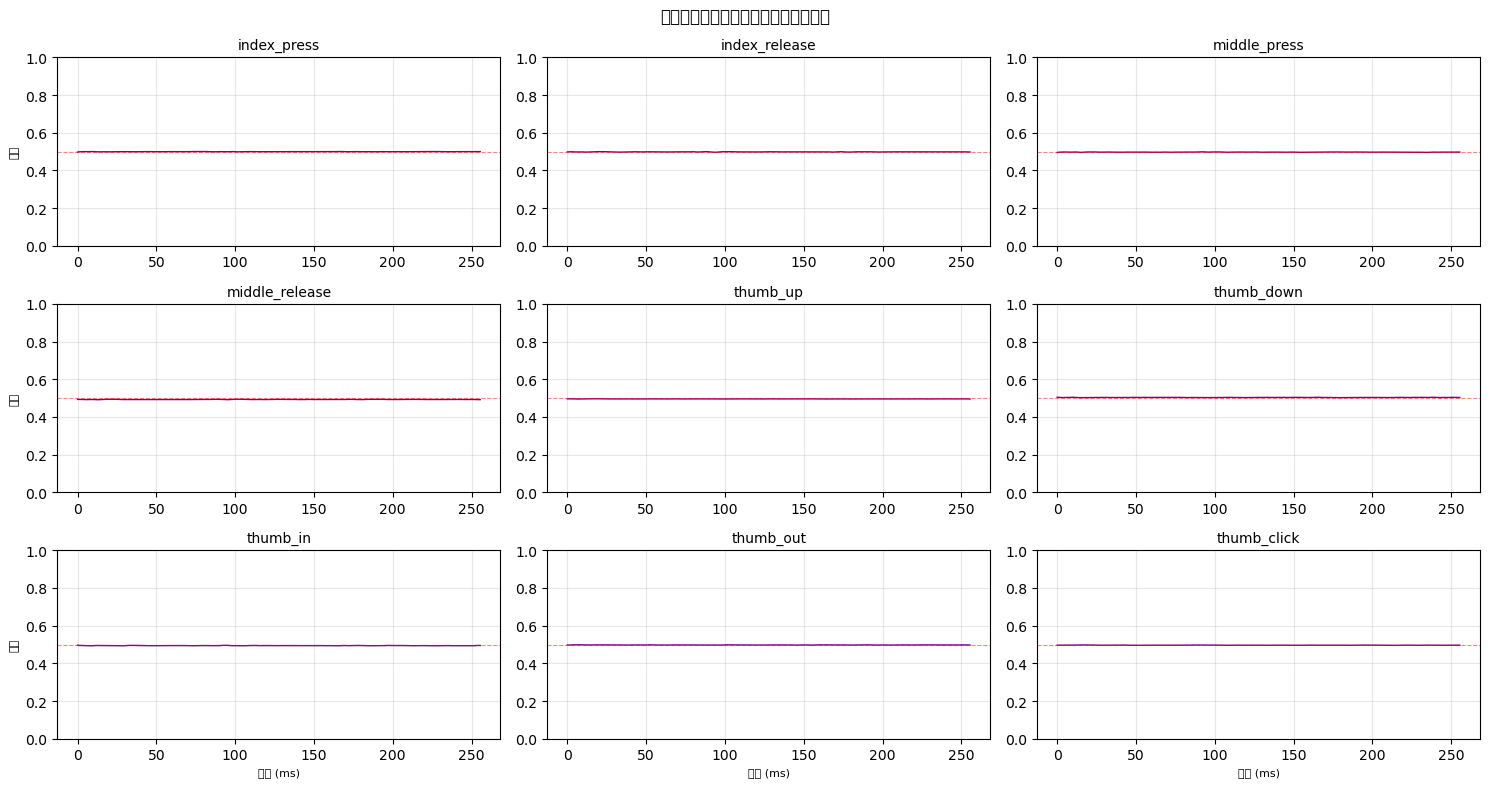

In [27]:
if sample_files:
    # 创建一个小batch测试
    test_batch_size = 4
    test_emg_batch = torch.stack([dataset[i][0] for i in range(test_batch_size)])
    
    print(f"测试输入: {test_emg_batch.shape}  (batch, time, channels)")
    
    with torch.no_grad():
        logits = model(test_emg_batch)
    
    print(f"模型输出: {logits.shape}  (batch, time, num_gestures)")
    print(f"输出范围: [{logits.min():.3f}, {logits.max():.3f}]")
    
    # 转换为概率
    probs = torch.sigmoid(logits)
    print(f"\n概率范围: [{probs.min():.3f}, {probs.max():.3f}]")
    print(f"平均概率: {probs.mean():.3f}")
    
    # 可视化第一个样本的预测
    fig, axes = plt.subplots(3, 3, figsize=(15, 8))
    fig.suptitle('未训练模型的预测概率（随机初始化）', fontweight='bold')
    
    time_ms = np.arange(WINDOW_SIZE) / SAMPLE_RATE * 1000
    
    for i in range(9):
        ax = axes[i // 3, i % 3]
        ax.plot(time_ms, probs[0, :, i].numpy(), linewidth=1, color='purple')
        ax.set_title(idx_to_gesture[i], fontsize=10)
        ax.set_ylim(0, 1)
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.grid(alpha=0.3)
        if i >= 6:
            ax.set_xlabel('时间 (ms)', fontsize=8)
        if i % 3 == 0:
            ax.set_ylabel('概率', fontsize=8)
    
    plt.tight_layout()
    plt.show()

## 10. 损失函数和掩码

使用BCE损失 + 手指状态掩码

In [29]:
class FingerStateMaskGenerator:
    """生成基于手指状态的掩码
    
    注意：当前数据集的手势类型与原始设计不同
    - index/middle有press/release配对
    - thumb动作是up/down/in/out/click，没有简单的press/release配对
    """
    
    def __init__(self):
        # 定义哪些手势是press，哪些是release（仅适用于index和middle）
        self.press_gestures = [
            gesture_to_idx['index_press'],
            gesture_to_idx['middle_press'],
        ]
        self.release_gestures = [
            gesture_to_idx['index_release'],
            gesture_to_idx['middle_release'],
        ]
        
        # 配对关系 (press_idx, release_idx)
        self.pairs = [
            (gesture_to_idx['index_press'], gesture_to_idx['index_release']),
            (gesture_to_idx['middle_press'], gesture_to_idx['middle_release']),
        ]
        
        print("⚠️  掩码生成器注意事项:")
        print(f"  - 仅对 index 和 middle 手指应用状态掩码")
        print(f"  - thumb 手势 (up/down/in/out/click) 不使用状态掩码")
    
    def generate_mask(self, targets: torch.Tensor) -> torch.Tensor:
        """
        生成掩码：只有在手指按下后才能检测释放
        Args:
            targets: (B, T, 9)
        Returns:
            mask: (B, T, 9)
        """
        B, T, C = targets.shape
        mask = torch.ones_like(targets)
        
        for b in range(B):
            for press_idx, release_idx in self.pairs:
                finger_pressed = False
                
                for t in range(T):
                    # 检测press事件
                    if targets[b, t, press_idx] > 0.5:
                        finger_pressed = True
                    
                    # 如果手指未按下，则屏蔽release检测
                    if not finger_pressed:
                        mask[b, t, release_idx] = 0.0
                    
                    # 检测release事件
                    if targets[b, t, release_idx] > 0.5:
                        finger_pressed = False
        
        return mask

# 测试掩码生成
if sample_files:
    mask_generator = FingerStateMaskGenerator()
    
    # 获取一个batch
    test_targets = torch.stack([dataset[i][1] for i in range(4)])
    mask = mask_generator.generate_mask(test_targets)
    
    print(f"\n目标形状: {test_targets.shape}")
    print(f"掩码形状: {mask.shape}")
    print(f"\n掩码统计:")
    print(f"  全部激活: {(mask == 1).sum().item()} / {mask.numel()}")
    print(f"  被屏蔽: {(mask == 0).sum().item()} / {mask.numel()}")
    print(f"  屏蔽比例: {(mask == 0).sum().item() / mask.numel() * 100:.1f}%")


⚠️  掩码生成器注意事项:
  - 仅对 index 和 middle 手指应用状态掩码
  - thumb 手势 (up/down/in/out/click) 不使用状态掩码

目标形状: torch.Size([4, 512, 9])
掩码形状: torch.Size([4, 512, 9])

掩码统计:
  全部激活: 14336 / 18432
  被屏蔽: 4096 / 18432
  屏蔽比例: 22.2%


## 11. 构建数据加载器

整合所有数据处理步骤

In [30]:
def build_dataloaders(data_dir: Path, split_csv: Path, batch_size: int):
    """构建训练/验证/测试数据加载器"""
    
    # 加载分割信息
    if not split_csv.exists():
        raise FileNotFoundError(f"Split CSV not found: {split_csv}")
    
    data_split = DataSplit.from_csv(split_csv)
    transform = DiscreteGesturesTransform(sample_rate=SAMPLE_RATE)
    
    def make_dataset(dataset_names, jitter=0.0):
        datasets = []
        print(f"Loading {len(dataset_names)} files...", end=' ')
        
        for name in tqdm(dataset_names, desc="[setup] Loading datasets"):
            filepath = data_dir / f"{name}.hdf5"
            if not filepath.exists():
                continue  # 跳过不存在的文件
            
            recording = EmgRecording(filepath, sample_rate=SAMPLE_RATE)
            dataset = WindowedEmgDataset(
                recording=recording,
                window_size=WINDOW_SIZE,
                window_stride=WINDOW_STRIDE,
                transform=transform,
                jitter=jitter
            )
            datasets.append(dataset)
        
        if not datasets:
            return None
        
        from torch.utils.data import ConcatDataset
        return ConcatDataset(datasets)
    
    # 针对small_subset的特殊处理
    all_files = list(data_dir.glob('*.hdf5'))
    if len(all_files) <= 3:
        print(f"⚠️  检测到小数据集({len(all_files)}个文件)，使用简化分割")
        all_names = [f.stem for f in all_files]
        train_dataset = make_dataset([all_names[0]], jitter=0.5)
        val_dataset = make_dataset([all_names[1]] if len(all_names) > 1 else [all_names[0]])
        test_dataset = make_dataset([all_names[2]] if len(all_names) > 2 else [all_names[0]])
    else:
        train_dataset = make_dataset(data_split.train_datasets, jitter=0.5)
        val_dataset = make_dataset(data_split.val_datasets)
        test_dataset = make_dataset(data_split.test_datasets)
    
    # 创建DataLoader
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=0, pin_memory=True
    ) if train_dataset else None
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    ) if val_dataset else None
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    ) if test_dataset else None
    
    return train_loader, val_loader, test_loader

# 构建数据加载器
print("\n" + "="*60)
print("构建数据加载器")
print("="*60 + "\n")

train_loader, val_loader, test_loader = build_dataloaders(
    DATA_DIR, SPLIT_CSV, BATCH_SIZE
)

print(f"\n✅ 数据加载器创建完成:")
if train_loader:
    print(f"  训练集: {len(train_loader)} 个batch")
if val_loader:
    print(f"  验证集: {len(val_loader)} 个batch")
if test_loader:
    print(f"  测试集: {len(test_loader)} 个batch")


构建数据加载器

Loading 956 files... 

[setup] Loading datasets: 100%|██████████| 956/956 [00:00<00:00, 41432.07it/s]


Loading 118 files... 

[setup] Loading datasets: 100%|██████████| 118/118 [00:00<00:00, 26344.17it/s]


Loading 118 files... 

[setup] Loading datasets: 100%|██████████| 118/118 [00:00<00:00, 25601.48it/s]


✅ 数据加载器创建完成:


### 查看一个训练batch

In [ ]:
if train_loader:
    # 获取一个batch
    batch_emg, batch_targets = next(iter(train_loader))
    
    print(f"📦 训练Batch详情:\n")
    print(f"EMG: {batch_emg.shape}  {batch_emg.dtype}")
    print(f"     范围: [{batch_emg.min():.3f}, {batch_emg.max():.3f}]")
    print(f"\n目标: {batch_targets.shape}  {batch_targets.dtype}")
    print(f"     激活率: {(batch_targets > 0).float().mean():.4f}")
    
    # 统计每个手势的激活频率
    print(f"\n每个手势的激活统计:")
    for i in range(9):
        count = (batch_targets[:, :, i] > 0).sum().item()
        total = batch_targets.shape[0] * batch_targets.shape[1]
        print(f"  {idx_to_gesture[i]:20s}: {count:4d} / {total} ({count/total*100:.2f}%)")

## 12. 训练循环

实现单个epoch的训练和验证

In [ ]:
def train_one_epoch(model, train_loader, optimizer, device, mask_generator):
    """训练一个epoch"""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for emg, targets in progress_bar:
        emg = emg.to(device)
        targets = targets.to(device)
        
        # 前向传播
        logits = model(emg)
        
        # 生成掩码
        mask = mask_generator.generate_mask(targets)
        
        # 计算损失（BCE with mask）
        loss = F.binary_cross_entropy_with_logits(
            logits, targets, weight=mask, reduction='mean'
        )
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches


@torch.no_grad()
def validate(model, val_loader, device, mask_generator):
    """验证模型"""
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    for emg, targets in tqdm(val_loader, desc="Validation"):
        emg = emg.to(device)
        targets = targets.to(device)
        
        logits = model(emg)
        mask = mask_generator.generate_mask(targets)
        
        loss = F.binary_cross_entropy_with_logits(
            logits, targets, weight=mask, reduction='mean'
        )
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

print("✅ 训练函数定义完成")

## 13. 完整训练流程

运行完整的训练循环

In [ ]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  使用设备: {device}\n")

# 创建模型
model = DiscreteGesturesArchitecture()
model = model.to(device)

# 创建优化器
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# 掩码生成器
mask_generator = FingerStateMaskGenerator()

# 训练历史
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []
}

best_val_loss = float('inf')
best_checkpoint_path = CHECKPOINT_DIR / 'best_discrete_gestures.pt'

print("="*60)
print("开始训练")
print("="*60 + "\n")

In [ ]:
# 训练循环
for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\n📅 Epoch {epoch}/{MAX_EPOCHS}")
    print("-" * 60)
    
    # 训练
    train_loss = train_one_epoch(model, train_loader, optimizer, device, mask_generator)
    
    # 验证
    val_loss = validate(model, val_loader, device, mask_generator)
    
    # 更新学习率
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)
    
    # 打印结果
    print(f"\n📊 Epoch {epoch} 结果:")
    print(f"   训练损失: {train_loss:.6f}")
    print(f"   验证损失: {val_loss:.6f}")
    print(f"   学习率: {current_lr:.6f}")
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, best_checkpoint_path)
        print(f"   ✅ 保存最佳模型 (val_loss: {val_loss:.6f})")

print("\n" + "="*60)
print("✅ 训练完成！")
print("="*60)

## 14. 训练曲线可视化

In [ ]:
if len(history['train_loss']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # 损失曲线
    ax = axes[0]
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'o-', label='训练损失', linewidth=2)
    ax.plot(epochs, history['val_loss'], 's-', label='验证损失', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('损失', fontsize=12)
    ax.set_title('训练和验证损失', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    # 学习率曲线
    ax = axes[1]
    ax.plot(epochs, history['lr'], 'o-', color='green', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('学习率', fontsize=12)
    ax.set_title('学习率变化', fontsize=14, fontweight='bold')
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 最佳验证损失: {min(history['val_loss']):.6f} (Epoch {np.argmin(history['val_loss']) + 1})")

## 15. 测试集评估

In [ ]:
# 加载最佳模型
if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ 加载最佳模型 (Epoch {checkpoint['epoch']})\n")

# 测试
test_loss = validate(model, test_loader, device, mask_generator)
print(f"\n🎯 测试集损失: {test_loss:.6f}")

## 16. 预测可视化

可视化模型在测试集上的预测

In [ ]:
# 获取测试集的一个batch
test_emg, test_targets = next(iter(test_loader))
test_emg = test_emg.to(device)
test_targets = test_targets.to(device)

# 预测
with torch.no_grad():
    test_logits = model(test_emg)
    test_probs = torch.sigmoid(test_logits)

# 转回CPU绘图
test_emg_cpu = test_emg[0].cpu().numpy()  # 第一个样本
test_targets_cpu = test_targets[0].cpu().numpy()
test_probs_cpu = test_probs[0].cpu().numpy()

# 可视化
fig, axes = plt.subplots(11, 1, figsize=(15, 14))
fig.suptitle('模型预测结果可视化', fontsize=16, fontweight='bold')

time_ms = np.arange(WINDOW_SIZE) / SAMPLE_RATE * 1000

# EMG信号（2个通道）
axes[0].plot(time_ms, test_emg_cpu[:, 0], label='通道0', linewidth=0.8, alpha=0.7)
axes[0].plot(time_ms, test_emg_cpu[:, 1], label='通道1', linewidth=0.8, alpha=0.7)
axes[0].set_ylabel('EMG', fontsize=9)
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, time_ms[-1])

# 9个手势的预测 vs 真实标签
for i in range(9):
    ax = axes[i+1]
    
    # 真实标签（蓝色填充）
    ax.fill_between(time_ms, 0, test_targets_cpu[:, i], 
                    color='blue', alpha=0.3, label='真实')
    
    # 预测概率（红色线条）
    ax.plot(time_ms, test_probs_cpu[:, i], 
           color='red', linewidth=1.5, label='预测')
    
    # 阈值线
    ax.axhline(0.5, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    ax.set_ylabel(idx_to_gesture[i].replace('_', '\n'), 
                 fontsize=7, rotation=0, ha='right', va='center')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, time_ms[-1])
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)
    
    if i < 8:
        ax.set_xticklabels([])

axes[-1].set_xlabel('时间 (ms)', fontsize=10)

plt.tight_layout()
plt.show()

# 统计预测准确率
threshold = 0.5
predictions = (test_probs_cpu > threshold).astype(float)
accuracy = (predictions == test_targets_cpu).mean()
print(f"\n✅ 样本级准确率: {accuracy*100:.2f}%")

## 17. 总结

### 完成的工作
1. ✅ 加载和探索EMG数据（HDF5格式，16通道，2000Hz）
2. ✅ 实现滑动窗口数据集（256ms窗口，50%重叠）
3. ✅ 实现离散手势转换器（事件时间→脉冲目标）
4. ✅ 构建模型（Conv1D→LSTM→Linear）
5. ✅ 训练模型（BCE损失 + 手指状态掩码）
6. ✅ 可视化结果（EMG信号、手势事件、模型预测）

### 数据流程
```
HDF5文件 → EmgRecording → WindowedEmgDataset → DataLoader
                ↓
        DiscreteGesturesTransform
                ↓
    (EMG窗口, 脉冲目标) → Model → 预测概率
```

### 模型架构
```
输入: (batch, 512, 16)
  ↓ ReinhardCompression
  ↓ Conv1d(16→512)
  ↓ LSTM(512, 3层)
  ↓ Linear(512→9)
输出: (batch, 512, 9)
```

### 下一步
- 增加训练epoch数（改`MAX_EPOCHS=250`）
- 下载完整数据集训练
- 调整超参数（学习率、batch size等）
- 实现更多评估指标（F1分数、精确率/召回率）